In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
LR_DQN = 0.0003
LR_RND = 0.0003
UP_COEF = 0.025
EX_COEF = 2.
IN_COEF = 1.
GAMMA = 0.99
EPS = 1e-8

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q


class FeatureNet(nn.Module):
    def __init__(self, obs_space):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        out = self.head(x)
        obs_feature = self.fc(out).reshape(out.shape[0], -1)

        return obs_feature

In [4]:
losses = []
f_losses = []


def learn(net, tgt_net, pred_net, rand_net, net_optim, pred_optim, rep_memory):
    global mean
    global std

    net.train()
    tgt_net.train()
    pred_net.train()
    rand_net.train()

    train_data = []
    train_data.extend(random.sample(rep_memory, BATCH_SIZE))

    dataloader = DataLoader(
        train_data,
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda
    )

    # double DQN
    for i, (s, a, r_ex, r_in, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()

        _s_norm = normalize_obs(_s.detach().cpu().numpy(), mean, std)
        _s_norm_batch = torch.tensor(_s_norm).to(device).float()
        r_ex_batch = r_ex.detach().to(device).float()
        r_in_batch = r_in.detach().to(device).float()
        r_batch = EX_COEF * r_ex_batch + IN_COEF * r_in_batch
        is_done = 1. - d.detach().reshape(BATCH_SIZE, 1).to(device).float()

        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)
        pred_features = pred_net(_s_norm_batch)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            action_space = _q_batch_tgt.shape[1]
            done_mask = torch.cat(
                tuple(is_done for _ in range(action_space)), dim=1)
            _q_batch_tgt_masked = _q_batch_tgt * done_mask
            _q_best_tgt = _q_batch_tgt_masked[range(BATCH_SIZE), _a_batch]
            rand_features = rand_net(_s_norm_batch)

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA*_q_best_tgt) - q_acting).pow(2).sum().mean()
        losses.append(loss)

        f_loss = (pred_features - rand_features).pow(2).sum(dim=1).mean()
        f_losses.append(f_loss)

        net_optim.zero_grad()
        loss.backward()
        net_optim.step()

        pred_optim.zero_grad()
        f_loss.backward()
        pred_optim.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = target_net(state)
        action = torch.argmax(q)

    return action.item()


def get_norm_params(obs_memory):
    global obs_apace

    obses = [[] for _ in range(obs_space)]
    for obs in obs_memory:
        for j in range(obs_space):
            obses[j].append(obs[j])

    mean = np.zeros(obs_space, np.float32)
    std = np.zeros(obs_space, np.float32)
    for i, obs_ in enumerate(obses):
        mean[i] = np.mean(obs_)
        std[i] = np.std(obs_)
    return mean, std


def normalize_obs(obs, mean, std):
    means = [mean for _ in range(BATCH_SIZE)]
    stds = [std for _ in range(BATCH_SIZE)]
    mean = np.stack(means)
    std = np.stack(stds)
    norm_obs = (obs - mean) / std

    return np.clip(norm_obs, -5, 5)


def calculate_reward_in(pred_net, rand_net, obs):
    global mean
    global std

    norm_obs = normalize_obs(obs, mean, std)
    state = torch.tensor([norm_obs]).to(device).float()
    with torch.no_grad():
        pred_obs = pred_net(state)
        rand_obs = rand_net(state)
        reward = (pred_obs - rand_obs).pow(2).sum()
        clipped_reward = torch.clamp(reward, -1, 1)

    return clipped_reward.item()

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 0.001
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make four nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)
pred_net = FeatureNet(obs_space).to(device)
rand_net = FeatureNet(obs_space).to(device)

# make optimizer
net_optim = torch.optim.Adam(net.parameters(), lr=LR_DQN, eps=EPS)
pred_optim = torch.optim.Adam(pred_net.parameters(), lr=LR_RND, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)
obs_memory = []

/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
use_cuda

True

In [7]:
env.spec.max_episode_steps

500

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

475.0

In [10]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    ep_reward_in = 0.
    while not done:
        env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)
        
        if not is_learned:
            obs_memory.append(obs)
            reward_in = 0.
        else:
            reward_in = calculate_reward_in(pred_net, rand_net, _obs)

        rep_memory.append((obs, action, reward, reward_in, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        ep_reward_in += reward_in
        
        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n====================  Start Learning  ====================\n')
                is_learned = True
                mean, std = get_norm_params(obs_memory)
                obs_memory.clear()
                
            learn(net, target_net, pred_net, rand_net,
                  net_optim, pred_optim, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}, reward_in {:.2f}'.format(
            i, total_steps, ep_reward, ep_reward_in))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in    10 steps, reward 10.00, reward_in 0.00
  2 Episode in    20 steps, reward 10.00, reward_in 0.00
  3 Episode in    28 steps, reward 8.00, reward_in 0.00
  4 Episode in    36 steps, reward 8.00, reward_in 0.00
  5 Episode in    44 steps, reward 8.00, reward_in 0.00
  6 Episode in    53 steps, reward 9.00, reward_in 0.00
  7 Episode in    63 steps, reward 10.00, reward_in 0.00
  8 Episode in    71 steps, reward 8.00, reward_in 0.00
  9 Episode in    80 steps, reward 9.00, reward_in 0.00
 10 Episode in    89 steps, reward 9.00, reward_in 0.00
 11 Episode in    99 steps, reward 10.00, reward_in 0.00
 12 Episode in   109 steps, reward 10.00, reward_in 0.00
 13 Episode in   119 steps, reward 10.00, reward_in 0.00
 14 Episode in   129 steps, reward 10.00, reward_in 0.00
 15 Episode in   138 steps, reward 9.00, reward_in 0.00
 16 Episode in   146 steps, reward 8.00, reward_in 0.00
 17 Episode in   155 steps, reward 9.00, reward_in 0.00
 18 Episode in   165 steps, reward 10.00,

150 Episode in  1405 steps, reward 8.00, reward_in 0.00
151 Episode in  1414 steps, reward 9.00, reward_in 0.00
152 Episode in  1424 steps, reward 10.00, reward_in 0.00
153 Episode in  1434 steps, reward 10.00, reward_in 0.00
154 Episode in  1444 steps, reward 10.00, reward_in 0.00
155 Episode in  1453 steps, reward 9.00, reward_in 0.00
156 Episode in  1463 steps, reward 10.00, reward_in 0.00
157 Episode in  1474 steps, reward 11.00, reward_in 0.00
158 Episode in  1482 steps, reward 8.00, reward_in 0.00
159 Episode in  1491 steps, reward 9.00, reward_in 0.00

====================  Start Learning  ====================

160 Episode in  1501 steps, reward 10.00, reward_in 1.00
161 Episode in  1510 steps, reward 9.00, reward_in 3.59
162 Episode in  1520 steps, reward 10.00, reward_in 2.43
163 Episode in  1529 steps, reward 9.00, reward_in 0.34
164 Episode in  1538 steps, reward 9.00, reward_in 0.08
165 Episode in  1548 steps, reward 10.00, reward_in 0.12
166 Episode in  1557 steps, reward 

293 Episode in 13983 steps, reward 209.00, reward_in 0.10
294 Episode in 14198 steps, reward 215.00, reward_in 0.07
295 Episode in 14421 steps, reward 223.00, reward_in 0.58
296 Episode in 14648 steps, reward 227.00, reward_in 0.16
297 Episode in 14854 steps, reward 206.00, reward_in 0.10
298 Episode in 15072 steps, reward 218.00, reward_in 0.09
299 Episode in 15278 steps, reward 206.00, reward_in 0.07
300 Episode in 15501 steps, reward 223.00, reward_in 0.09
301 Episode in 15731 steps, reward 230.00, reward_in 0.06
302 Episode in 15945 steps, reward 214.00, reward_in 0.05
303 Episode in 16170 steps, reward 225.00, reward_in 0.04
304 Episode in 16451 steps, reward 281.00, reward_in 0.08
305 Episode in 16724 steps, reward 273.00, reward_in 0.07
306 Episode in 17011 steps, reward 287.00, reward_in 0.05
307 Episode in 17328 steps, reward 317.00, reward_in 0.08
308 Episode in 17718 steps, reward 390.00, reward_in 0.10
309 Episode in 18218 steps, reward 500.00, reward_in 0.09
310 Episode in

435 Episode in 73674 steps, reward 500.00, reward_in 0.08
436 Episode in 74174 steps, reward 500.00, reward_in 0.03
437 Episode in 74674 steps, reward 500.00, reward_in 0.03
438 Episode in 75174 steps, reward 500.00, reward_in 0.04
439 Episode in 75589 steps, reward 415.00, reward_in 0.04
440 Episode in 76089 steps, reward 500.00, reward_in 0.03
441 Episode in 76589 steps, reward 500.00, reward_in 0.02
442 Episode in 77089 steps, reward 500.00, reward_in 0.02
443 Episode in 77589 steps, reward 500.00, reward_in 0.03
444 Episode in 78016 steps, reward 427.00, reward_in 0.03
445 Episode in 78516 steps, reward 500.00, reward_in 0.03
446 Episode in 79016 steps, reward 500.00, reward_in 0.04
447 Episode in 79516 steps, reward 500.00, reward_in 0.02
448 Episode in 80016 steps, reward 500.00, reward_in 0.05
449 Episode in 80516 steps, reward 500.00, reward_in 0.10
450 Episode in 81016 steps, reward 500.00, reward_in 0.04
451 Episode in 81479 steps, reward 463.00, reward_in 0.07
452 Episode in

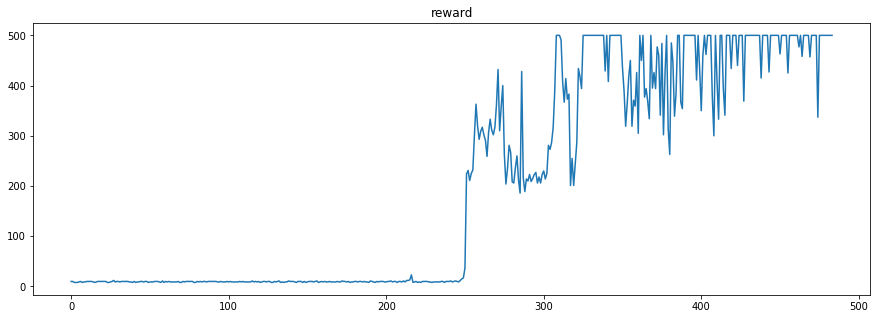

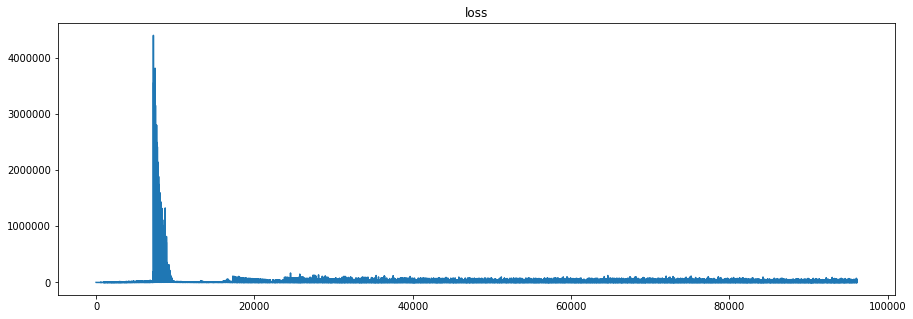

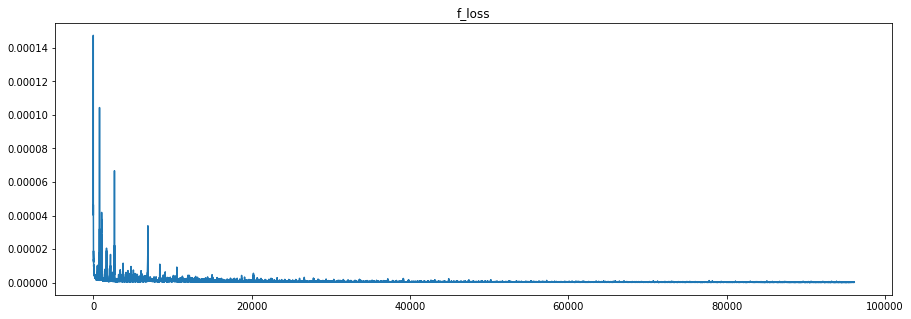

In [11]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('loss')
plt.plot(losses)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('f_loss')
plt.plot(f_losses[30:])
plt.show()

In [15]:
[
    ('CartPole-v0', 355, 0.5),
    ('CartPole-v1', 484, 0.025),
    ('MountainCar-v0', 245, 0.05),
]

[('CartPole-v0', 355, 0.5),
 ('CartPole-v1', 484, 0.025),
 ('MountainCar-v0', 245, 0.05)]